In [7]:
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from mappymatch.maps.nx.nx_map import NxMap
from mappymatch.maps.nx.readers.osm_readers import parse_osmnx_graph, NetworkType
from mappymatch.matchers.lcss.lcss import LCSSMatcher

import bachelors_thesis.util as util

In [8]:
data_path = "../../data"

In [9]:
road_graph_og = util.load_graph(f"{data_path}/road_graph/road_graph_ox_nsl.pickle")
road_graph = util.load_graph(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc.pickle")
cameras_info = util.load(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc_cameras.pickle")

In [10]:
trajectories_traces_dict = dict()
with open(f"{data_path}/dataset/trajectories.json", mode="r", encoding="utf-8") as file:
    for line in file:
        trajectory = json.loads(line)
        trajectory["xyt"].sort(key=lambda l: l[2])
        trace = list()
        for x, y, _ in trajectory["xyt"]:
            gps_points = util.xy_to_epsg4326(np.array([[x, y]]))
            lon = gps_points[0, 0]
            lat = gps_points[0, 1]
            trace.append([lon, lat])
        trajectories_traces_dict[trajectory["vehicle_id"]] = trace

vehicle_records_traces_dict = defaultdict(list)
with open(f"{data_path}/dataset/records-annotated.json", mode="r", encoding="utf-8") as file:
    for line in file:
        record = json.loads(line)
        vehicle_id = record["vehicle_id"]
        timestamp = record["time"]
        camera_id = record["camera_id"]
        node = cameras_info[camera_id]["node_id"]
        lon, lat = road_graph.nodes[node]["x"], road_graph.nodes[node]["y"]
        vehicle_records_traces_dict[vehicle_id].append([lon, lat, timestamp])

for vehicle_records in vehicle_records_traces_dict.values():
    vehicle_records.sort(key=lambda r: r[2])
    for vehicle_record in vehicle_records:
        vehicle_record.pop()

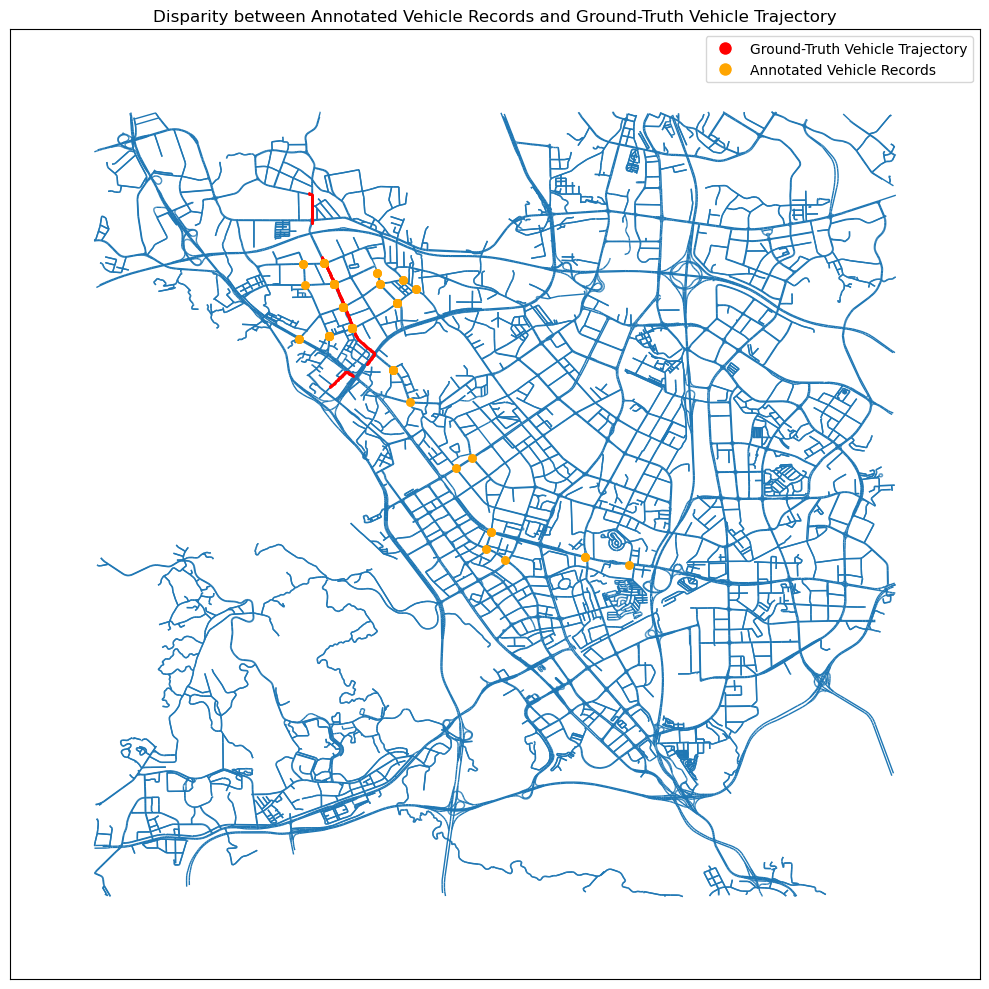

In [11]:
# Good map-matching: 32
# Poor map-matching: 72
# Disparity with ground-truth: 32
vehicle_id = 72

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pos = {node: (road_graph_og.nodes[node]["x"], road_graph_og.nodes[node]["y"]) for node in road_graph_og.nodes()}

nx.draw_networkx_edges(
    road_graph_og,
    pos,
    arrows=False,
    edge_color="#1f77b4",
    ax=ax
)

trajectory = np.array(trajectories_traces_dict[vehicle_id])
ax.scatter(trajectory[:, 0], trajectory[:, 1], s=1, c="red")

vehicle_records = np.array(vehicle_records_traces_dict[vehicle_id])
ax.scatter(vehicle_records[:, 0], vehicle_records[:, 1], s=30, c="orange")

legend = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10,
               label=f"Ground-Truth Vehicle Trajectory"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="orange", markersize=10,
               label=f"Annotated Vehicle Records"),
]

ax.set_title("Disparity between Annotated Vehicle Records and Ground-Truth Vehicle Trajectory")
ax.legend(handles=legend)

plt.tight_layout()
plt.savefig(f"{data_path}/graphics/records-vs-gt-trajectory.pdf")
plt.show()

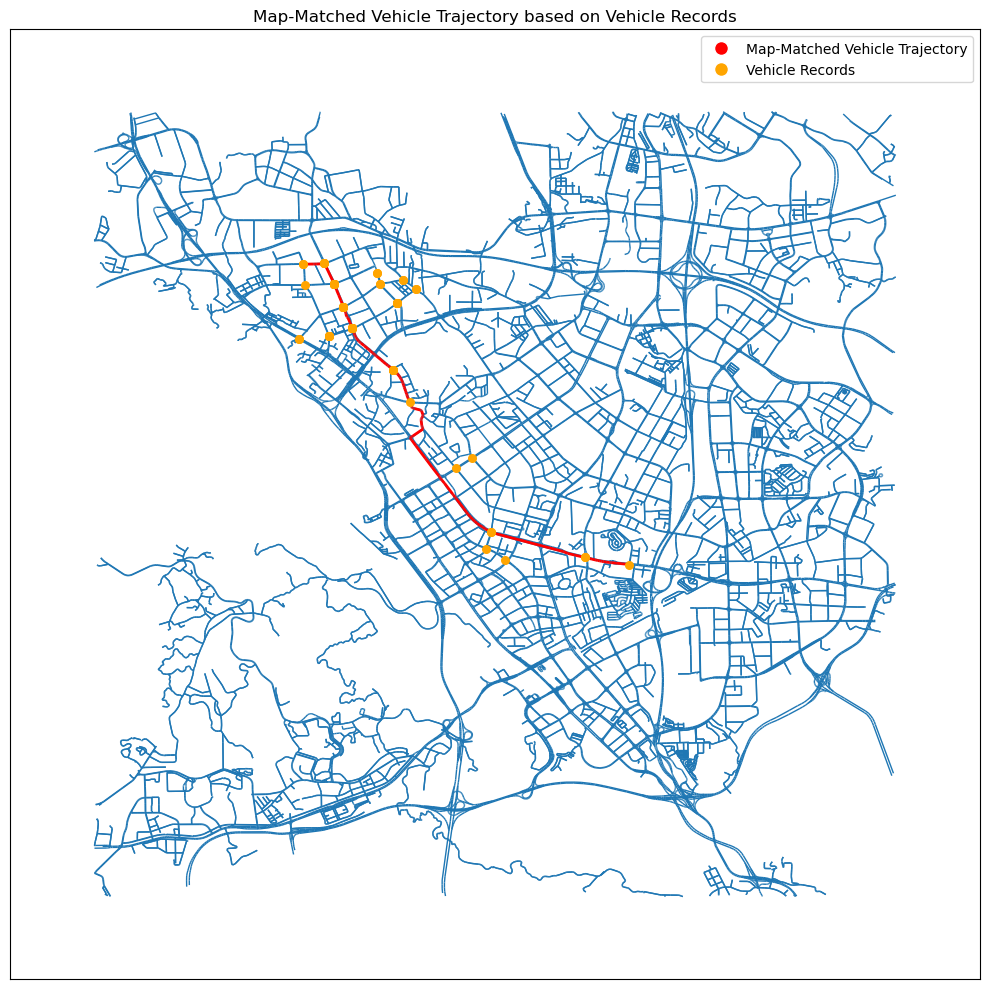

In [12]:
road_map = NxMap(parse_osmnx_graph(road_graph_og, network_type=NetworkType.DRIVE, xy=True))
matcher = LCSSMatcher(road_map)
match_result = matcher.match_trace(util.get_trace_from_list(vehicle_records))
path_df = match_result.path_to_dataframe()
path = util.get_node_path(path_df, road_graph_og)
path_edges = list(zip(path, path[1:]))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx_edges(
    road_graph_og,
    pos,
    arrows=False,
    edge_color="#1f77b4",
    ax=ax
)

nx.draw_networkx_edges(
    road_graph_og,
    pos,
    edgelist=path_edges,
    edge_color="red",
    width=2,
    arrows=False,
    ax=ax
)

ax.scatter(vehicle_records[:, 0], vehicle_records[:, 1], s=30, c="orange")

legend = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10,
               label=f"Map-Matched Vehicle Trajectory"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="orange", markersize=10,
               label=f"Vehicle Records"),
]

ax.set_title("Map-Matched Vehicle Trajectory based on Vehicle Records")
ax.legend(handles=legend)

plt.tight_layout()
plt.savefig(f"{data_path}/graphics/records-vs-mm-trajectory.pdf")
plt.show()